Using TensorFlow backend.


Nb of hidden layers = 3
Shape of layer # 0
(300, 785)
Shape of layer # 1
(300, 301)
Shape of layer # 2
(300, 301)
Shape of layer # 3
(10, 301)


epoch : 1 / 50
[=================================================================================================== ] 99.9%
Accuracy on validation data:0.1122000000



epoch : 2 / 50
[=================================================================================================== ] 99.9%
Accuracy on validation data:0.1122000000



epoch : 3 / 50
[=================================================================================================== ] 99.9%
Accuracy on validation data:0.1122000000



epoch : 4 / 50
[=================================================================================================== ] 99.9%
Accuracy on validation data:0.1122000000



epoch : 5 / 50
[=================================================================================================== ] 99.9%
Accuracy on validation data:0.1122000000



epoch : 6 / 50


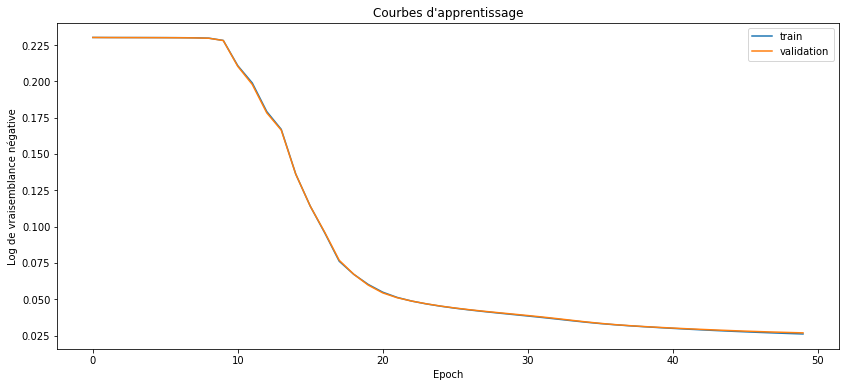

In [1]:
import numpy as np
import sys
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def one_hot(y, K):
    y_one_hot = np.zeros((y.shape[0], K))  # we have K classes, the general form is len(np.unique(y)
    y_one_hot[np.arange(y.shape[0]), y] = 1  # one hot target or shape NxK
    return y_one_hot

def softmax(x):
    # this condition is for debugging purposes,
    # so we could detect exploding gradients
    if (np.isnan(x).any()):
        print('There is nan in softmax')
    expZ = np.exp(x - np.amax(x, axis=1, keepdims=True))
    return np.divide(expZ, np.sum(expZ, axis=1, keepdims=True))


def softmax_backward(y, y_pred):
    return (y - y_pred)


def relu(x):
    # this test condition is for debugging purposes,
    # so we could detect exploding gradients
    if (np.isnan(x).any()):
        print('There is nan in relu')
    return np.maximum(x, 0)


def relu_backward(X):
    x = np.copy(X)
    x[x < 0] = 0.0
    x[x >= 0] = 1.0
    # we do not use the diagonal form of the matrix but we use the vector instead,
    # then we do an elementwise product later
    return x


def get_loss(y, y_pred):
    eps = 1.0e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)  # to prevent dividing by zero
    #a = - np.mean(y * np.log(y_pred))
    return - np.nanmean(y * np.log(y_pred))


def get_accuracy(y_pred, y):
    a = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) / len(y)
    return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) / len(y)


class NeuralNetwork:
    def __init__(self,
                 no_of_in_nodes,
                 no_of_out_nodes,
                 no_of_hidden_nodes,
                 no_of_hidden_layers):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.no_of_hidden_layers = no_of_hidden_layers
        self.Teta = self.create_weight_matrices()

    # generating matrix Teta of weights = [ W  b ]
    def create_weight_matrices(self):
        Teta = []
        print("Nb of hidden layers = " + str(self.no_of_hidden_layers))
        for i in range(0, self.no_of_hidden_layers + 1):
            if i == 0:
                input_nodes = self.no_of_in_nodes
                output_nodes = self.no_of_hidden_nodes
            elif i == self.no_of_hidden_layers:
                input_nodes = self.no_of_hidden_nodes
                output_nodes = self.no_of_out_nodes
            else:
                input_nodes = self.no_of_hidden_nodes
                output_nodes = self.no_of_hidden_nodes
            print("Shape of layer # " + str(i))
            Teta_layer = np.random.normal(0, 0.01,
                                          (output_nodes, input_nodes + 1))  # we add +1 to take b into consideration
            print(Teta_layer.shape)
            Teta.append(Teta_layer)
        return Teta  # list of np arrays
    """
    # a non optimised version of predict function, another version is below
    def predict_large(self, X):
        L = self.no_of_hidden_layers
        node_in = [None] * (L + 2)  # [[] for i in range(L + 2)]
        node_a = [None] * (L + 2)
        node_a[0] = np.copy(X)  # item j from the input vector of the example
        for l in range(1, L + 2):
            node_in[l] = node_a[l - 1] @ self.Teta[l - 1].T  # in_i <- sum_j{W_j_i * a_j}
            if l < L + 1:
                # the hidden layers
                node_a[l] = relu(node_in[l])  # relu
                node_a[l] = np.concatenate((node_a[l], np.ones((node_a[l].shape[0], 1))),
                                           axis=1)  # add the bias b to use it in the next layer
            else:
                # the output layer
                node_a[l] = softmax(node_in[l])
        return node_a[L+1]
    """
    # an optimised version of predict function
    def predict(self, X):
        # feedforward for all the examples and predict the output
        L = self.no_of_hidden_layers
        # forward pass for each example
        node_a_prev = np.copy(X)  # item j from the input vector of the example
        for l in range(1, L + 2):
            node_in = np.dot(node_a_prev, self.Teta[l - 1].T)  # in_i <- sum_j{W_j_i * a_j}
            if l < L + 1:
                # the hidden layers
                node_a_cur = relu(node_in)  # relu
                node_a_cur = np.concatenate((node_a_cur, np.ones((node_a_cur.shape[0], 1))), axis=1)  # add the bias b
            else:
                # the output layer
                node_a_cur = softmax(node_in)
            node_a_prev = np.copy(node_a_cur)
        return node_a_cur

    def progress(self,i,n):
        sys.stdout.write('\r')
        # just a fancy progress bar:
        sys.stdout.write("[%-100s] %.1f%%" % ('=' * int(i*100/n), (100/n)*i))
        sys.stdout.flush()

    def train(self, X_train, y_train, X_validation, y_validation, X_test, y_test, lr, nb_epochs,minibatch_size):
        # neural network with L hidden layers
        L = self.no_of_hidden_layers

        best_teta = None
        best_accuracy = 0
        losses_train = []
        losses_val = []
        accuracies = []

        for epoch in range(nb_epochs):
            loss = 0
            accuracy = 0
            print("\n\nepoch : "+str(epoch+1)+" / "+str(nb_epochs))

            for i in range(0, X_train.shape[0], minibatch_size):
                X_train_mini = X_train[i:i + minibatch_size] if (i + minibatch_size < X_train.shape[0]) \
                    else X_train[i:X_train.shape[0]]
                y_train_mini = y_train[i:i + minibatch_size] if (i + minibatch_size < X_train.shape[0]) \
                    else y_train[i:X_train.shape[0]]

                self.progress(i,len(X_train))
                # forward pass for each example
                node_in = [None] * (L + 2) # [[] for i in range(L + 2)]
                node_a = [None] * (L + 2)
                node_delta = [None] * (L + 2)
                node_a[0] = X_train_mini # item j from the input vector of the example
                for l in range(1, L + 2):
                    TetaT = np.fastCopyAndTranspose(self.Teta[l - 1])
                    node_in[l] = node_a[l - 1] @ TetaT  # in_i <- sum_j{Teta_j_i * a_j}

                    if l < L + 1:
                        # the hidden layers
                        node_a[l] = relu(node_in[l]) # relu
                        node_a[l] = np.concatenate((node_a[l], np.ones((node_a[l].shape[0], 1))),
                                                    axis=1)  # add the bias b to use it in the next layer
                    else:
                        # the output layer
                        node_a[l] = softmax(node_in[l])

                # backpropagation
                y = y_train_mini
                node_delta[L + 1] = softmax_backward(y, node_a[L + 1])
                for l in range(L, 0, -1):
                    node_delta[l] = relu_backward(node_a[l][:,:-1]) * ((node_delta[l + 1] @ self.Teta[l][:, :-1]))  # W.T @ node_delta[l + 1]

                # update parameters
                for l in range(0, L+1):
                    self.Teta[l] = self.Teta[l] + lr * (node_delta[l + 1].T @ node_a[l])  #* 1 / len(node_a[l]) #(node_delta[l + 1].T @ node_a[l])
                    # self.Teta[l] = np.clip(self.Teta[l], -1000.0, 1000.0)

            # compute the loss on the train set
            y_train_pred = self.predict(X_train)
            loss = get_loss(y_train, y_train_pred)
            losses_train.append(loss)

            # compute the loss on the validation set
            y_validation_pred = self.predict(X_validation)
            loss = get_loss(y_validation, y_validation_pred)
            losses_val.append(loss)

            # compute the accuracy on the validation set
            accuracy = get_accuracy(y_validation_pred, y_validation)
            accuracies.append(accuracy)
            print("\nAccuracy on validation data:{:.10f}\n".format(accuracy))

            if accuracy > best_accuracy:
                # select the best parameters based on the validation accuracy
                best_accuracy = accuracy
                best_teta = self.Teta

        # set Teta to the best matrix weights to use it to test the model on unseen data
        self.Teta = best_teta
        y_test_pred = self.predict(X_test)
        # compute the accuracy on the test set
        accuracy_on_unseen_data = get_accuracy(y_test_pred, y_test)
        print("\nBest Accuracy on validation data:{:.10f}\n".format(best_accuracy))
        print("Accuracy on unseen data:{:.10f}\n".format(accuracy_on_unseen_data))
        return losses_train, losses_val, best_teta, best_accuracy

def run():
    ((X_train, y_train), (X_test, y_test)) = mnist.load_data()

    X_train = X_train.reshape((X_train.shape[0], 28 ** 2))
    X_test = X_test.reshape((X_test.shape[0], 28 ** 2))

    # scale data to the range of [0, 1]
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0
    # append bias to X
    X_train = np.concatenate((X_train,np.ones((X_train.shape[0], 1))), axis=1)
    X_test = np.concatenate((X_test,np.ones((X_test.shape[0], 1))), axis=1)
    # one-hot encode the training and testing labels
    y_train = one_hot(y_train, 10)
    y_test = one_hot(y_test, 10)
    # shuffle the dataset
    X_train, y_train = shuffle(X_train,y_train)

    X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    NN = NeuralNetwork(no_of_in_nodes=784, no_of_out_nodes=10, no_of_hidden_nodes=300, no_of_hidden_layers=3)

    losses_train, losses_val, best_teta, best_accuracy = NN.train(X_train[:], y_train[:],
                                                                  X_validation, y_validation,
                                                                  X_test, y_test,
                                                                  lr=0.0001, nb_epochs=50, minibatch_size=32)

    plt.figure(figsize=(14, 6))

    plt.plot(losses_train, label="train")
    plt.plot(losses_val, label="validation")
    plt.title('Courbes d\'apprentissage')
    plt.ylabel('Log de vraisemblance négative')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.show()

run()

Train: 0.305, Test: 0.383


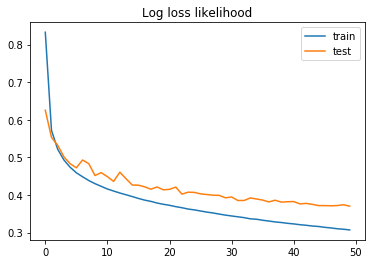

In [10]:
# implementation for the model with high-level framework
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import numpy as np

def one_hot(y, K):
    y_one_hot = np.zeros((y.shape[0], K))  # we have K classes, the general form is len(np.unique(y)
    y_one_hot[np.arange(y.shape[0]), y] = 1  # one hot target or shape NxK
    return y_one_hot

# generate fashion mnist dataset
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

X_train = X_train.reshape((X_train.shape[0], 28 ** 2))
X_test = X_test.reshape((X_test.shape[0], 28 ** 2))

# scale data to the range of [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
# one-hot encode the training and testing labels
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)


# split test into validation and test
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# define model
model = Sequential()
model.add(Dense(300, input_dim=784, activation='relu', kernel_initializer='he_uniform',bias_initializer='ones' , use_bias=True))
model.add(Dense(300, activation='relu', kernel_initializer='he_uniform', bias_initializer='ones' , use_bias=True))
model.add(Dense(300, activation='relu', kernel_initializer='he_uniform', bias_initializer='ones' , use_bias=True))
model.add(Dense(10, activation='softmax', kernel_initializer='he_uniform', bias_initializer='ones' , use_bias=True))
# compile model
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001))
# fit model
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_validation, y_validation), epochs=50, verbose=0)
# evaluate the model
train_error = model.evaluate(X_train, y_train, verbose=0)
test_error = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_error, test_error))
# plot loss during training
pyplot.title('Log loss likelihood')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()